# Testing out numerical solver code

## current setup
implicit - explicit solver with an implicit multigrid solver for the diffusion term and RK45 for the reaction term.

## Objectives 

## Model considerations 
* Species
    1. Cell density (sender and pulse cells)
    1. Nutrient density 
    1. mScarlet
* Reactions 
    1. cell growth and diffusion 
        * Cells diffuse very slowly
        * nutrient-dependent growth (from Liu et al 2011, Science) 
        $$  $$ 
    1. Constitutive fluorescence
        * Basal protein expression 
        * initial protein concentration set to fixed point of max nutrient
    1. Dilution and degradation 
        * Assume that all proteins are degradation tagged
    1. Diffusion 
        * Here, you're going to use convoultion of the diffusion kernel
        * Diffusion in/out of cell is considered faster than spatial diffusion at these scales
    1. Parameters
        * We are also assuming, for the moment, that each time point is 6 minutes. Parameters with time dimensions shown below may use different units than the parameter from the cited paper.
        * dx: Length modification of diffusion terms. In the compartmental model, diffusion is calculated via Ficks' first law, where the flux between two adjacent compartments is equal to the flux multiplied by the area of the interface between the components :  
        $\frac{\mathrm{d} C}{\mathrm{d} t} $ 
        in continuous form gives up 
        $\Delta C = D \frac{A}{V} \frac{\Delta C}{\Delta x} = D \frac{2.25 \cdot 5 \cdot \mathrm{scale}^2 \mathrm{mm}^2}{\mathrm{scale} \cdot 2.25^2 \cdot 5 \mathrm{mm}^3} \frac{\Delta C \cdot \mathrm{scale}}{2.25 \mathrm{mm}} = \frac{D \Delta C \mathrm{scale}^2}{2.25^2 \mathrm{mm}^2}$. the dx parameter below is the symbol $A$ in this equation.
        * Dc : Diffusion rate for cells. $7\frac{mm^2}{min}$
        * rc : Division rate of cells. $\frac{1.14}{min}$
        * Kn : Half-point of nutrient availability. 75
        * Dn : Diffusion rate of nutrient. $28\frac{mm^2}{min}$
        * kn : Consumption rate of nutrient by cells
        * Da : Diffusion rate of nutrient. $28\frac{mm^2}{min}$
        * xs : Expression rate of protein. 


### Model equations
Species:
* $c_p$ : Propagator cells
* $c_s$ : Sender cells
* $n$ : Nutrient
* $a$ : AHL (cell-cell signaling molecule)
* $s$ : Synthase (protein that creates AHL)
* $r$ : Transcriptional repressor (halts production of synthase)

Parameters
* $h_i$ : Hill coefficient
* $k_i$ : Hill function IC50 concentration
* $r_i$ : Species production rate
* $p_i$ : Species degradation or consumption rate
* $D_i$ : Species diffusion coefficient

Inducer-dependent protein production approximation:

$ H(a, n, k) = \frac{a^n}{k^n + a^n}$

$ H_n(a, n, k) = 1 - H(a,n,k) $

Differential equations

$ \partial_t c_p = D_c \Delta c_p + r_c H(n,h_n,90)\,c_p $

$ \partial_t c_s = D_c \Delta c_p + r_c H(n,h_n,90)\,c_s $

$ \partial_t n = D_n \Delta n - p_n H(n,h_n,90)\,(c_p + c_s) $

$ \partial_t a = D_a \Delta a + r_a\,s\,(c_p+c_s)-p_a\,a $

Where $c_s>0$

$ \partial_t s = D_c \Delta s  + (r_s\,c_s - r_c\,s)\,H(n,h_n,90) - p_s\,s$

Where $c_p>0$

$ \partial_t s = D_c \Delta s  + (r_s\,c_p\, H(a,h_s,k_s) H_n(r,h_C,k_C) - r_c\,s)\,H(n,h_n,90) - p_s\,s$

Where both $c_p=0$ and $c_s=0$

$ \partial_t s = D_c \Delta s - p_p\,s$

Where $c_p>0$

$ \partial_t r = D_c \Delta r  + (r_r\,c_p\, H(a,h_r,k_r) - r_c\,r)\,H(n,h_n,90) - p_r\,r$

Where both $c_p=0$ 

$ \partial_t r = D_c \Delta r - p_r\,r$


Inducer-dependent protein production approximation:

$ H(a, n, k) = \frac{a^n}{k^n + a^n}$

Differential equations

$ \partial_t c = D_c \Delta c + r_c H(n,h_n,90)\,c $

$ \partial_t n = D_n \Delta n - k_n H(n,h_n,90)\,c $


In [38]:
# imports
from __future__ import division, print_function

import itertools as itt
import time

import numpy as np
import pandas as pd
import os
import sys
import string
import selenium
import scipy.integrate as itg
import scipy.optimize as opt
import scipy.stats as stats
import scipy.interpolate as itp
import scipy.ndimage as ndi
import scipy.sparse as sparse

import matplotlib as mpl
mpl.use("Agg")

import itertools

import matplotlib.pyplot as plt 
plt.rcParams['animation.ffmpeg_path'] = '/home/jparkin/anaconda3/bin/ffmpeg' # Add the path of ffmpeg here!!

import matplotlib.animation as anm
import skimage.measure
import skimage.filters
import numba
import gc

from multiprocessing import Pool, Process

# %load_ext memory_profiler
# %load_ext line_profiler
import timeit

from IPython.display import HTML

%matplotlib inline

## 2D Discrete Laplacian

In continuous form : 
$$ U_t = \triangle U - \lambda U $$

In discrete form, for point $i$ : 
$$ \Delta U_i = \sum_{1 = w(i,j)}\omega(i,j)(U_i - U_j) - \lambda U_i $$

Use discrete laplacian approximation w/o diagonals for grid spacing, so that we can have zero-flux  boundary conditions. 

$$ L = 
 \begin{pmatrix}
  0 & 1 & 0 \\
  1 & -4 & 1 \\
  0 & 1 & 0 
 \end{pmatrix} $$

I use a convolution function to calculate the diffusion terms. 

In [2]:
cs_i, cp_i, n_i, a_i, s_i, r_i = np.arange(6)
def write_movie(im_arr, t_vec, skip=1, n_frames=200):
    
    frames, s, h, w = im_arr.shape
    t_points = np.arange(0,t_vec.max(),n_frames)
    f_points = np.arange(frames)
    
    #frames = len(t)
    
    t, s, h, w = im_arr.shape
    xticks = []
    xticklabels = []
    # First set up the figure, the axis, and the plot element we want to animate
    blank_array = np.zeros([h, w])
    fig, axs = plt.subplots(2,3, figsize=(10,7))
    axs = axs.flatten()
    im_list = [0,0,0,0,0,0]
    
    # Plot cell densities
    ax_ind = 0
    ax = axs[ax_ind]
    indxs = [cp_i, cs_i]
    vmax = im_arr[-1,indxs,:,:].sum(axis=0).max()
    vmin = im_arr[-1,indxs,:,:].sum(axis=0).min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks([])
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('cell densities')
    im_list[ax_ind] = im
    
    # Plot nutrient densities
    ax_ind = 1
    ax = axs[ax_ind]
    indxs = [n_i]
    vmax = im_arr[:,indxs[0],:,:].max()
    vmin = im_arr[:,indxs[0],:,:].min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('nutrient')
    im_list[ax_ind] = im
    
    # Plot pulser synthase densities
    ax_ind = 2
    ax = axs[ax_ind]
    indxs = [s_i, cp_i]
    v_arr = im_arr[:,indxs,:,:].prod(axis=1)
    indxs = [s_i, cs_i]
    v_arr += im_arr[:,indxs,:,:].prod(axis=1)
    vmax = v_arr.max()
    vmin = v_arr.min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('synthases')
    im_list[ax_ind] = im
    
    # Plot ahl conc
    ax_ind = 3
    ax = axs[ax_ind]
    indxs = [a_i]
    v_arr = im_arr[:,indxs,:,:]
    vmax = v_arr.max()
    vmin = v_arr.min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('ahl')
    im_list[ax_ind] = im
    
    # Plot pulser repressor densities
    ax_ind = 4
    ax = axs[ax_ind]
    indxs = [r_i, cp_i]
    v_arr = im_arr[:,indxs,:,:].prod(axis=1)
    vmax = v_arr.max()
    vmin = v_arr.min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('repr')
    im_list[ax_ind] = im
    
    # Plot total cellular protein
    ax_ind = 5
    ax = axs[ax_ind]
    indxs = [s_i, r_i]
    v_arr = im_arr[:,indxs,:,:].sum(axis=1)
    vmax = v_arr.max()
    vmin = v_arr.min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('cellular protein')
    im_list[5] = im

    # animation function.  This is called sequentially
    t_points = np.linspace(0,t_vec.max(), 200)
    f_inds = []
    t_ind = 0
    for tp in t_points:
        while tp > t_vec[t_ind]:
            t_ind += 1
        f_inds.append(t_ind-1)
        
    def animate(t_point):
        i = f_inds[t_point]
        
        # Plot cell densities
        ax = axs[0]
        indxs = [cp_i, cs_i]
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[0].set_array(frame_arr)

        # Plot nutrient densities
        ax = axs[1]
        indxs = [n_i]
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[1].set_array(frame_arr)

        # Plot synthase densities
        ax = axs[2]
        indxs = [s_i, cp_i]
        frame_arr = im_arr[i,indxs,:,:].prod(axis=0)
        indxs = [s_i, cs_i]
        frame_arr += im_arr[i,indxs,:,:].prod(axis=0)
        im_list[2].set_array(frame_arr)
        
        # Plot ahl
        ax = axs[3]
        indxs = [a_i]
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[3].set_array(frame_arr)

        # Plot repr
        ax = axs[4]
        indxs = [cp_i, r_i]
        frame_arr = im_arr[i,indxs,:,:].prod(axis=0)
        im_list[4].set_array(frame_arr)

        # Plot cellular protein
        ax = axs[5]
        indxs = [s_i, r_i]
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[5].set_array(frame_arr)

        #return im_list,

    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = anm.FuncAnimation(fig, animate, interval=50, frames=n_frames)

#     anim.save('./animation_test.gif', writer='pillow')
#     fig.tight_layout()
    plt.close('all')
    return anim
#     HTML(anim.to_html5_video())


def prep_initial_condition(cs_spots, cp_spots, ahl_spots, dims, p0, A):
    rp,    Kn,  Dn, Da, xs, xS, xr, hS, hR, kR, hC, pa, leak, od = p0
    species, n_h, n_w = dims
    
    cs_cells = np.zeros((n_h, n_w), dtype=np.float32)
    for center in cs_spots:
        cs_cells += disk(cs_cells, np.array(center), scale_s)*od
        
    cp_cells = np.zeros((n_h, n_w), dtype=np.float32)
    for center in cp_spots:
        cp_cells += disk(cp_cells, np.array(center), scale_s)*od
        
    ahl_drops = np.zeros((n_h, n_w), dtype=np.float32)
    for center in ahl_spots:
        ahl_drops += disk(ahl_drops, np.array(center), scale_s)*2.5e3
    
    # Set initial conditions
    for ind, cell_arr in zip([cs_i, cp_i], [cs_cells, cp_cells]):
        A[ind,:,:] += cell_arr
#         A[ind,:,:] += ndi.filters.gaussian_filter(cell_arr, scale_s)
    
    # External cin AHL.
    A[a_i,:,:] += ndi.filters.gaussian_filter(ahl_drops, scale_s)
    
    return A



# this no cell diffusion, no nutrient diffusion, seems to work

In [3]:
import importlib
from omnisim import nodc_omnisim as oms
oms = importlib.reload(oms)

In [13]:

# array([1.13884719e-06, 2.57810284e-04, 6.79690366e+01, 3.97094713e+00,
#        1.57994650e-02])
# Params :    ,Dc,      rc,        rS, rR,  Hn, Kn,   Dn,      kn,                   
p0 = np.array([0*1e-5,  2.6e-4, 2e-4, 8e-6,  4, 68,  0, (1.6e-2),
# Da,   xa,                xs,  xS,
2e-4, (2e-6), 250, 300, 
#xr, hS,   kS,  hR, kR,  hC,  kC,    pa,  leak   min_od
13, 2.5,  133, 2.3, 40, 2.2, 1.13e4, 6e-5, 0, 0.005], dtype=np.float64)
# Define parameter values to sample
Dc,rc,rS,rR,Hn,Kn,Dn,kn,Da,xa,xs,xS,xr,hS,kS,hR,kR,hC,kC,pa,leak,min_od = p0
od0 = 0.05

simmer = oms.Simulator(4)
scale = simmer.scale
# simmer.set_scale(8)
# simmer.t_eval = np.arange(0,24*60,2).astype(np.float)

In [14]:
simmer.basedims = np.array([2,22])
simmer.set_scale(simmer.scale)

In [15]:

species, nh, nw, dx = simmer.dims
initial_array = np.zeros((species, nh, nw), dtype=np.float64, order='C')
initial_array[n_i,:,:] = 100
initial_array[cs_i,0,:4*scale] = od0
# initial_array[cs_i,:,:] = od0*(np.random.random((nh,nw))<0.19)
# initial_array[cs_i,0,:] = ndi.gaussian_filter(initial_array[cs_i,:,:], scale/8)
initial_array[cp_i,0,4*scale:] = od0
# initial_array[cp_i,:,:] = od0*(np.random.random((nh,nw))<0.25)
# initial_array[cp_i,:,:] = ndi.gaussian_filter(initial_array[cp_i,:,:], scale/8)
# for ind in [cp_i, cs_i]:
#     threshed = initial_array[ind,:,:] > min_od
#     initial_array[ind,:,:] = initial_array[ind,:,:]*threshed

simmer.initial_array = initial_array


In [6]:

xa_vals = np.power(10,np.linspace(-8,-4,100))
print(xa_vals)

[1.00000000e-08 1.09749877e-08 1.20450354e-08 1.32194115e-08
 1.45082878e-08 1.59228279e-08 1.74752840e-08 1.91791026e-08
 2.10490414e-08 2.31012970e-08 2.53536449e-08 2.78255940e-08
 3.05385551e-08 3.35160265e-08 3.67837977e-08 4.03701726e-08
 4.43062146e-08 4.86260158e-08 5.33669923e-08 5.85702082e-08
 6.42807312e-08 7.05480231e-08 7.74263683e-08 8.49753436e-08
 9.32603347e-08 1.02353102e-07 1.12332403e-07 1.23284674e-07
 1.35304777e-07 1.48496826e-07 1.62975083e-07 1.78864953e-07
 1.96304065e-07 2.15443469e-07 2.36448941e-07 2.59502421e-07
 2.84803587e-07 3.12571585e-07 3.43046929e-07 3.76493581e-07
 4.13201240e-07 4.53487851e-07 4.97702356e-07 5.46227722e-07
 5.99484250e-07 6.57933225e-07 7.22080902e-07 7.92482898e-07
 8.69749003e-07 9.54548457e-07 1.04761575e-06 1.14975700e-06
 1.26185688e-06 1.38488637e-06 1.51991108e-06 1.66810054e-06
 1.83073828e-06 2.00923300e-06 2.20513074e-06 2.42012826e-06
 2.65608778e-06 2.91505306e-06 3.19926714e-06 3.51119173e-06
 3.85352859e-06 4.229242

In [ ]:
# A = cnmg.cn_lhsA(h)
# x = im_arr[1,:,:,:].flatten()

sim_tmpl = './worker_outputs/linear_3d_xa_i{}.tif'
tvc_tmpl = './worker_outputs/linear_3d_xa_i{}_tvc.npy'
dt = 3
xa_vals = np.power(10,np.linspace(-8,-4,100))
for xa_i, xa in enumerate(xa_vars):        
    ys = []
    ts = []
    p0=np.array([Dc,rc,rS,rR,Hn,Kn,Dn,kn,Da,xa,xs,xS,xr,hS,kS,hR,kR,hC,kC,pa,leak,min_od])
    simmer.set_p0(p0)
    simmer.sim(p0, method='RK45')
    out_fn = sim_tmpl.format(xa_i)
    skimage.io.imsave(out_fn,simmer.sim_arr,plugin='tifffile')
    out_fn = tvc_tmpl.format(xa_i)
    np.save(out_fn, simmer.sim_tvc)
    print(out_fn)
    

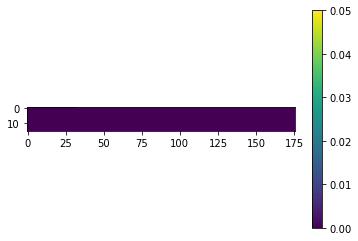

In [7]:
# simmer.initial_array.shape = simmer.dims[:-1]
plt.imshow(simmer.initial_array[cp_i,...])
plt.colorbar()

In [16]:
# simmer.initial_array = initial_array
# simmer.t_eval = np.arange(0,24*60*60,2.0).astype(np.float)
simmer.set_p0(p0)
_, nh, nw, dx = simmer.dims
simmer.t_eval = np.linspace(0,15*60*60,200)
rtime = time.time()
print('start')
simmer.sim(p0, method='RK45')
# simmer.sim(p0, method='BDF')
rtime = time.time() - rtime
print(rtime/60)

start
0.08694960276285807


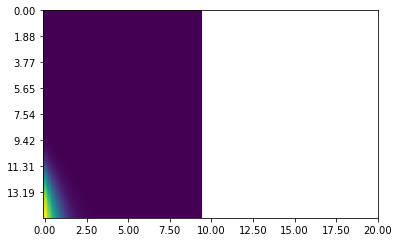

In [17]:
plt.imshow(simmer.sim_arr[:,s_i,0,50:],aspect=1/4)
_ = plt.yticks(np.arange(0,200,25),['{:0.2f}'.format(xx/3600) for xx in simmer.t_eval[np.arange(0,200,25)]])
_ = plt.xticks(np.arange(0,nw,10),['{:0.2f}'.format(xx) for xx in np.arange(0,nw,10)/scale])

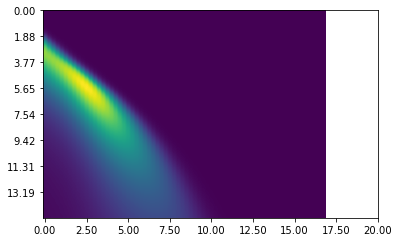

In [9]:
plt.imshow(simmer.sim_arr[:,s_i,0,20:],aspect=1/4)
_ = plt.yticks(np.arange(0,200,25),['{:0.2f}'.format(xx/3600) for xx in simmer.t_eval[np.arange(0,200,25)]])
_ = plt.xticks(np.arange(0,nw,10),['{:0.2f}'.format(xx) for xx in np.arange(0,nw,10)/scale])

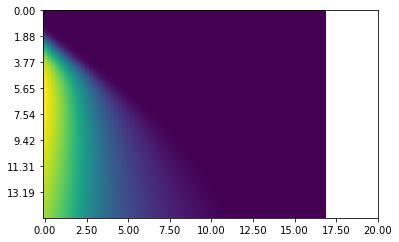

In [10]:
plt.imshow(simmer.sim_arr[:,r_i,0,20:],aspect=1/4)
_ = plt.yticks(np.arange(0,200,25),['{:0.2f}'.format(xx/3600) for xx in simmer.t_eval[np.arange(0,200,25)]])
_ = plt.xticks(np.arange(0,nw,10),['{:0.2f}'.format(xx) for xx in np.arange(0,nw,10)/scale])

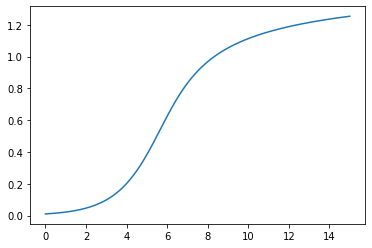

In [82]:
plt.plot(simmer.sim_tvc/3600,simmer.sim_arr[:,cp_i,0,20])

In [18]:
pads_list = []
pads_list.append((simmer.sim_arr.copy(), simmer.sim_tvc.copy()))

In [29]:
# simmer = pads_list[0][0]
movie_obj = write_movie(pads_list[0][0][:,:,:1,20::2], pads_list[0][1], skip=1, n_frames=200)
HTML(movie_obj.to_html5_video())

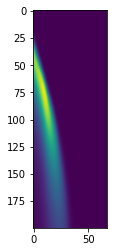

In [37]:
plt.imshow(pads_list[0][0][:,s_i,0,20:],vmin=0,vmax=5e4)

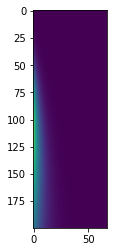

In [35]:
plt.imshow(pads_list[1][0][:,a_i,0,20:],vmin=0,vmax=1e3)

In [20]:

# Define parameter values to sample
# Dc,rc,rS,rR,Hn,Kn,Dn,kn,Da,xa,xs,xS,xr,hS,kS,hR,kR,hC,kC,pa,leak,min_od = p0
xs=0
p0 = np.array([Dc,rc,rS,rR,Hn,Kn,Dn,kn,Da,xa,xs,xS,xr,hS,kS,hR,kR,hC,kC,pa,leak,min_od])

# simmer.t_eval = np.arange(0,24*60*60,2.0).astype(np.float)
# simmer.basedims = np.array([2,22])
# simmer.set_scale(simmer.scale)
simmer.set_p0(p0)

species, nh, nw, dx = simmer.dims
initial_array = np.zeros((species, nh, nw), dtype=np.float64, order='C')
initial_array[n_i,:,:] = 100
initial_array[cs_i,0,:4*scale] = od0
# initial_array[cs_i,:,:] = od0*(np.random.random((nh,nw))<0.19)
# initial_array[cs_i,0,:] = ndi.gaussian_filter(initial_array[cs_i,:,:], scale/8)
initial_array[cp_i,0,4*scale:] = od0
# initial_array[cp_i,:,:] = od0*(np.random.random((nh,nw))<0.25)
# initial_array[cp_i,:,:] = ndi.gaussian_filter(initial_array[cp_i,:,:], scale/8)
# for ind in [cp_i, cs_i]:
#     threshed = initial_array[ind,:,:] > min_od
#     initial_array[ind,:,:] = initial_array[ind,:,:]*threshed

simmer.initial_array = initial_array


simmer.t_eval = np.linspace(0,15*60*60,200)
rtime = time.time()
print('start')
simmer.sim(p0, method='RK45')
# simmer.sim(p0, method='BDF')
rtime = time.time() - rtime
print(rtime/60)

start


/home/jparkin/anaconda3/lib/python3.7/site-packages/scipy/integrate/_ivp/common.py:41: UserWarning: The following arguments have no effect for a chosen solver: `jac`.
  .format(", ".join("`{}`".format(x) for x in extraneous)))


0.08306116660435994


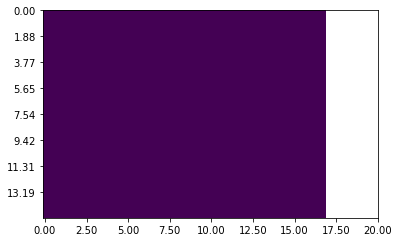

In [16]:
plt.imshow(simmer.sim_arr[:,s_i,0,20:],aspect=1/4)
_ = plt.yticks(np.arange(0,200,25),['{:0.2f}'.format(xx/3600) for xx in simmer.t_eval[np.arange(0,200,25)]])
_ = plt.xticks(np.arange(0,nw,10),['{:0.2f}'.format(xx) for xx in np.arange(0,nw,10)/scale])

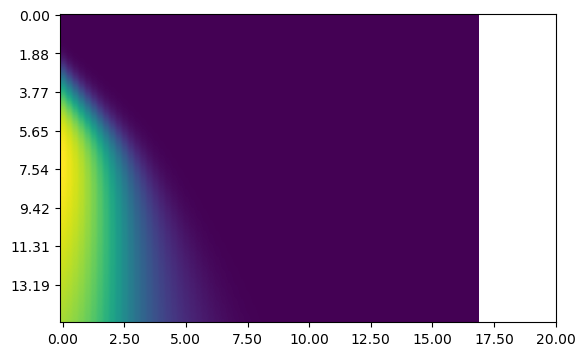

In [88]:
plt.imshow(simmer.sim_arr[:,r_i,0,20:],aspect=1/4)
_ = plt.yticks(np.arange(0,200,25),['{:0.2f}'.format(xx/3600) for xx in simmer.t_eval[np.arange(0,200,25)]])
_ = plt.xticks(np.arange(0,nw,10),['{:0.2f}'.format(xx) for xx in np.arange(0,nw,10)/scale])

In [21]:
pads_list.append((simmer.sim_arr.copy(), simmer.sim_tvc.copy()))

In [22]:
movie_obj = write_movie(simmer.sim_arr, simmer.sim_tvc, skip=1, n_frames=200)
HTML(movie_obj.to_html5_video())

chan:0 pad:0 fit:[ 1.18198237 -3.27517817  3.99999999]
chan:0 pad:1 fit:[ 1.07478285 -3.07961532  2.87500043]
chan:1 pad:0 fit:[ 1.04893659 -1.58278571  8.24999999]


/home/jparkin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Legend does not support None instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


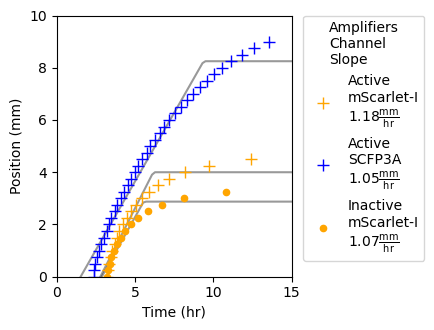

In [130]:

# import downsampled movie
# pad_procs = [procpad1, procpad2]
# pad_styles = ['dashed', 'solid']
pad_styles = ['+', '.']
offset_vals = [4*scale, 4*scale]
# rot_vals = [3.8, -11]
np_slices = np.s_[0,4*scale:], np.s_[0,4*scale:]

chan_vals = [0,1,2]
col_vals = ['yellow','orange','blue']
# max_vals = [10000,5000,10000]
# max_vals = [1e4,500,200]
max_vals = [1e4,1e4,3e4]
# max_vals = [100,30,130]

col_vals = ['yellow','orange','blue']
# frame_vals = np.arange(0,25,1)
plt.style.use('default')
plt.style.use('fast')
fig, axs = plt.subplots(1,1,figsize=(4.5,3.4))
handles = [[None,None],[None,None]]
ys = []
cs = []
ts = []
ps = []
dirs = []
handles = [[None,None],[None,None]]
df_list = []
for np_sl, ls, pad_tup, pad_ind in zip(np_slices, pad_styles, pads_list, [0,1]):
#     procpad = mma.ProcessUnorderedDiff(acq, pad_ind, 2, overwrite=False, bg_option='pos_list',sigma=1,bg_sigma=16)
#     procpad._load_arrs(False)
    sim_arr, sim_tvc = pad_tup
    pixel_size = 1/scale
#     pad_ind = procpad.pad_ind
    spec_inds = [r_i, s_i]
    for chan_ind, spec_i in enumerate(spec_inds):
        c = col_vals[chan_ind+1]
        frame_img = sim_arr[:,[cp_i,spec_i],np_sl[0],np_sl[1]].prod(axis=1)
        if np.all(frame_img <1):
            continue
        thresh_val = np.max([skimage.filters.threshold_otsu(frame_img),1e1])
        bool_arr = frame_img>(thresh_val)
        if np.any(bool_arr):
            tcross = [[simmer.sim_tvc[xvec][0], xi] for xi, xvec in enumerate(bool_arr.T) if np.any(xvec)]
            cross_arr = np.array(tcross)
            h = axs.plot(cross_arr[:,0]/3600, cross_arr[:,1]*pixel_size,c=c,linestyle='none',ms=9,marker=ls)
            handles[pad_ind][chan_ind] = h[0]
            # update lists
#             ys.append(y_val)
#             ts.append(t_val)
#             cs.append(chan_ind)
#             ps.append(procpad.pad_ind)
#             dirs.append(acq.super_dir)
#             axs.set_title("Chan {} Frame {}".format(chan_ind, frame_ind))
            axs.set_ylim([0,10])
            tmp_df = pd.DataFrame(cross_arr, columns=['time','dist'])
            tmp_df['channel'] = chan_ind
            tmp_df['pad'] = pad_ind
            df_list.append(tmp_df)
            axs.set_xlim([0,15])
        axs.set_xlabel('Time (hr)')
        axs.set_ylabel('Position (mm)')

def f_fun(t,p):
    a, b, c = p
    return np.array([np.min([c,xx]) for xx in (a*t + b)])

def res_fun(p, t, y):
    a, b, c = p
    if (a < 0) or (b > 0):
        return -np.inf
    return -1*np.sum(stats.norm.logpdf(f_fun(t,p)-y,scale=0.5))


cols = ['dist','time','channel','pad']
fit_df = pd.concat(df_list,ignore_index=True)
labels=['Active\nmScarlet-I\n{:0.2f}',
        'Active\nSCFP3A\n{:0.2f}',
        'Inactive\nmScarlet-I\n{:0.2f}',
        'Inactive\nSCFP3A\n{:0.2f}']
for key, chan_df in fit_df.groupby(['channel','pad']):
    chan, pad = key
    y_vec = chan_df.dist.values*pixel_size
    t_vec = chan_df.time.values/3600
    p0 = np.array([3,-15,np.max(y_vec)])
    out = opt.minimize(res_fun, p0, args=(t_vec, y_vec))
    color = col_vals[chan]
    sim_t = np.linspace(0,15,80)
    sim_y = f_fun(sim_t, out.x)
    axs.plot(sim_t, sim_y, 'k-',alpha=0.4,zorder=0)
    label_i = (chan)+2*(pad)
    label = labels[label_i]
    labels[label_i] = label.format(out.x[0])+r'$\frac{\mathrm{mm}}{\mathrm{hr}}$'
    print('chan:{} pad:{} fit:{}'.format(chan, pad, out.x))

axs.legend(handles=handles[0]+handles[1], labels=labels,title='Amplifiers\nChannel\nSlope',
          bbox_to_anchor=(1.05,1),loc='upper left',borderaxespad=0.)
fig.tight_layout()
fig.savefig('/home/jparkin/groupdir/biotek/summary-analysis/figures/nodc_3d_propagation.png')
fig.savefig('/home/jparkin/groupdir/biotek/summary-analysis/figures/nodc_3d_propagation.pdf')

In [107]:
3600/np.mean(np.diff(pads_list[0][1]))

13.266666666666666

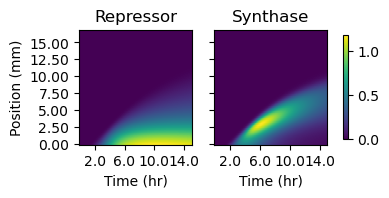

In [13]:
plt.style.use('default')
plt.style.use('fast')
pixel_size = 1/scale
fig, axs = plt.subplots(1,2,figsize=(4,3))
ax = axs[1]
yvec = np.arange(0,nw-5*scale,10)
yvec_labels = ['{:0.2f}'.format(xx) for xx in yvec*pixel_size]
xvec = np.arange(27,200,53)
xvec_labels = ['{:0.1f}'.format(xx/3600) for xx in pads_list[0][1][xvec]]
ax.imshow(pads_list[0][0][:,[cp_i,s_i],0,20:].prod(axis=1).T,aspect=3,origin='lower')
ax.set_xticks(xvec)
ax.set_xticklabels(xvec_labels)
ax.set_xlabel('Time (hr)')
_ = ax.set_yticks(yvec)
_ = ax.set_yticklabels(['' for xx in yvec])

ax.set_title('Synthase')


ax = axs[0]
ax.set_title('Repressor')
h = ax.imshow(pads_list[0][0][:,[cp_i,r_i],0,20:].prod(axis=1).T/np.max(pads_list[0][0][:,r_i,0,20:].T),aspect=3,origin='lower')
ax.set_xticks(xvec)
ax.set_xticklabels(xvec_labels)
ax.set_xlabel('Time (hr)')
_ = ax.set_yticks(yvec)
ax.set_ylabel('Position (mm)')
_ = ax.set_yticklabels(yvec_labels)
plt.colorbar(h,ax=axs,shrink=0.45)
# fig.tight_layout()
# fig.savefig('/home/jparkin/groupdir/biotek/summary-analysis/figures/nodc_3d_heatmap.png',bbox_inches='tight')
# fig.savefig('/home/jparkin/groupdir/biotek/summary-analysis/figures/nodc_3d_heatmap.pdf',bbox_inches='tight')

In [25]:
fig.savefig?

/home/jparkin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


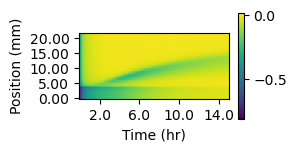

In [132]:
fig, ax = plt.subplots(1,1,figsize=(3,2))
arr = ((pads_list[0][0][:,a_i,1,:].T-pads_list[0][0][:,a_i,0,:].T))#/(simmer.sim_arr[:,a_i,0,:].T)
# arr = scale*xa*((simmer.sim_arr[:,s_i,0,:].T*simmer.sim_arr[:,[cs_i,cp_i],0,:].sum(axis=1).T))
arr /= pads_list[0][0][:,a_i,0,:].T
h = ax.imshow(arr,aspect=1,interpolation='none',origin='lower')
ax.set_xticks(xvec)
ax.set_xticklabels(xvec_labels)
ax.set_xlabel('Time (hr)')
yvec = np.arange(0,nw,10)
yvec_labels = ['{:0.2f}'.format(xx) for xx in yvec*pixel_size]
_ = ax.set_yticks(yvec[::2])
ax.set_ylabel('Position (mm)')
_ = ax.set_yticklabels(yvec_labels[::2])
plt.colorbar(h,ax=ax,shrink=0.65)
fig.tight_layout()
ax.set_title('')
fig.savefig('/home/jparkin/groupdir/biotek/summary-analysis/figures/nodc_3d_depthratio.png')
fig.savefig('/home/jparkin/groupdir/biotek/summary-analysis/figures/nodc_3d_depthratio.pdf')

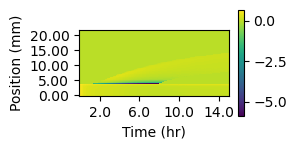

In [82]:
plt.style.use('default')
plt.style.use('fast')
fig, ax = plt.subplots(1,1,figsize=(3,2))
img_arr = pads_list[0][0]
arr = (img_arr[:,a_i,1,:].T-img_arr[:,a_i,0,:].T)
arr *= Da*scale**2
arr /= xa*scale*(1e-4+img_arr[:,[cp_i,s_i],0,:].prod(axis=1).T + img_arr[:,[cs_i,s_i],0,:].prod(axis=1).T)
arr += 1
tmp_arr = xa*scale*(img_arr[:,[cp_i,s_i],0,:].prod(axis=1).T + img_arr[:,[cs_i,s_i],0,:].prod(axis=1).T)
bool_arr = tmp_arr < 5e-2
arr[bool_arr] = 0
h = ax.imshow(arr[:,:],aspect=1,interpolation='none',origin='lower')
pixel_size = 1/scale
xvec = np.arange(27,200,53)
xvec_labels = ['{:0.1f}'.format(xx/3600) for xx in pads_list[0][1][xvec]]
ax.set_xticks(xvec)
ax.set_xticklabels(xvec_labels)
ax.set_xlabel('Time (hr)')
yvec = np.arange(0,nw,10)
yvec_labels = ['{:0.2f}'.format(xx) for xx in yvec*pixel_size]
_ = ax.set_yticks(yvec[::2])
ax.set_ylabel('Position (mm)')
_ = ax.set_yticklabels(yvec_labels[::2])
plt.colorbar(h,ax=ax,shrink=0.65)
fig.tight_layout()
_ = ax.set_title('')
# fig.savefig('/home/jparkin/groupdir/biotek/summary-analysis/figures/nodc_3d_depthratio.png')
# fig.savefig('/home/jparkin/groupdir/biotek/summary-analysis/figures/nodc_3d_depthratio.pdf')

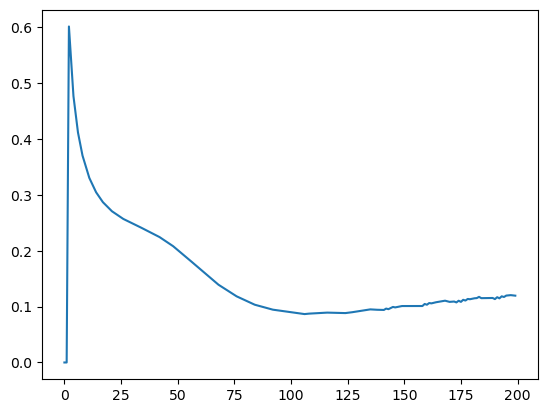

In [86]:
# tmp_arr = xa*scale*(img_arr[:,[cp_i,s_i],0,:].prod(axis=1).T + img_arr[:,[cs_i,s_i],0,:].prod(axis=1).T)
# _ =plt.imshow(tmp_arr)
# _ = plt.plot(tmp_arr[38,:])
_ = plt.plot(arr[8,:])

In [43]:

# def f_fun(t,p):
#     a, b, c = p
#     return a*t + b

# def res_fun(p, t, y):
#     return -1*np.sum(scipy.stats.cauchy.logpdf(f_fun(t,p)-y,scale=1))

def f_fun(t,p):
    a, b, c = p
    return np.array([np.min([c,xx]) for xx in (a*t + b)])

def res_fun(p, t, y):
    return -1*np.sum(stats.norm.logpdf(f_fun(t,p)-y,scale=0.5))


cols = ['dist','time','channel','fn','pad']
data = [ys, ts, cs, dirs, ps]
fit_df = pd.DataFrame(dict(zip(cols,data)))
labels=['Active\nmScarlet-I\n{:0.2f}',
        'Active\nSCFP3A\n{:0.2f}',
        'Inactive\nmScarlet-I\n{:0.2f}',
        'Inactive\nSCFP3A\n{:0.2f}']
for key, chan_df in fit_df.groupby(['channel','pad']):
    chan, pad = key
    y_vec = chan_df.dist.values
    t_vec = chan_df.time.values
    p0 = np.array([1,-0.5,np.max(y_vec)])
    out = opt.minimize(res_fun, p0, args=(t_vec, y_vec))
    color = col_vals[chan]
    sim_t = np.linspace(t_vec.min(),t_vec.max(),30)
    sim_y = f_fun(sim_t, out.x)
    axs.plot(sim_t, sim_y, 'k-',alpha=0.4,zorder=0)
    label_i = (chan-1)+2*(pad)
    label = labels[label_i]
    labels[label_i] = label.format(out.x[0])+r'$\frac{\mathrm{mm}}{\mathrm{hr}}$'
    print('chan:{} pad:{} fit:{}'.format(chan, pad, out.x))

axs.legend(handles=handles[0]+handles[1], labels=labels,title='Amplifiers\nChannel\nSlope',
          bbox_to_anchor=(1.05,1),loc='upper left',borderaxespad=0.)
fig.tight_layout()
# fig.savefig('/home/jparkin/groupdir/biotek/summary-analysis/figures/191217_propagation.png')
# fig.savefig('/home/jparkin/groupdir/biotek/summary-analysis/figures/191217_propagation.pdf')

/home/jparkin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Legend does not support None instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


# this no cell diffusion, no nutrient diffusion, seems to work

In [17]:
import importlib
from omnisim import nodc_omnisim as oms
oms = importlib.reload(oms)

In [36]:

# array([1.13884719e-06, 2.57810284e-04, 6.79690366e+01, 3.97094713e+00,
#        1.57994650e-02])
# Params :    ,Dc,      rc,        rS, rR,  Hn, Kn,   Dn,      kn,                   
p0 = np.array([0*1e-5,  2.6e-4, 2e-4, 8e-6,  4, 68,  0, (1.6e-2),
# Da,   xa,                xs,  xS,
2e-4, (2e-6), 250, 300, 
#xr, hS,   kS,  hR, kR,  hC,  kC,    pa,  leak   min_od
13, 2.5,  133, 2.3, 40, 2.2, 1.13e4, 3e-5, 0, 0.005], dtype=np.float64)
# Define parameter values to sample
Dc,rc,rS,rR,Hn,Kn,Dn,kn,Da,xa,xs,xS,xr,hS,kS,hR,kR,hC,kC,pa,leak,min_od = p0
od0 = 0.05

simmer = oms.Simulator(4)
scale = simmer.scale
# simmer.set_scale(8)
# simmer.t_eval = np.arange(0,24*60,2).astype(np.float)

In [36]:

# array([1.13884719e-06, 2.57810284e-04, 6.79690366e+01, 3.97094713e+00,
#        1.57994650e-02])
# Params :    ,Dc,      rc,        rS, rR,  Hn, Kn,   Dn,      kn,                   
p0 = np.array([0*1e-5,  2.6e-4, 2e-4, 8e-6,  4, 68,  0, (1.6e-2),
# Da,   xa,                xs,  xS,
2e-4, (3e-7), 250, 300, 
#xr, hS,   kS,  hR, kR,  hC,  kC,    pa,  leak   min_od
13, 2.5,  133, 2.3, 40, 2.2, 1.13e4, 3e-5, 0, 0.005], dtype=np.float64)
# Define parameter values to sample
Dc,rc,rS,rR,Hn,Kn,Dn,kn,Da,xa,xs,xS,xr,hS,kS,hR,kR,hC,kC,pa,leak,min_od = p0
od0 = 0.05

simmer = oms.Simulator(4)
scale = simmer.scale
# simmer.set_scale(8)
# simmer.t_eval = np.arange(0,24*60,2).astype(np.float)

In [37]:
simmer.basedims = np.array([4,22])
simmer.set_scale(simmer.scale)

In [38]:

species, nh, nw, dx = simmer.dims
initial_array = np.zeros((species, nh, nw), dtype=np.float64, order='C')
initial_array[n_i,:,:] = 100
initial_array[cs_i,:,:4*scale] = od0
initial_array[cs_i,0,:4*scale] = od0
# initial_array[cs_i,:,:] = od0*(np.random.random((nh,nw))<0.19)
# initial_array[cs_i,0,:] = ndi.gaussian_filter(initial_array[cs_i,:,:], scale/8)
initial_array[cp_i,:,4*scale:] = od0
initial_array[cp_i,0,4*scale:] = od0
# initial_array[cp_i,:,:] = od0*(np.random.random((nh,nw))<0.25)
# initial_array[cp_i,:,:] = ndi.gaussian_filter(initial_array[cp_i,:,:], scale/8)
# for ind in [cp_i, cs_i]:
#     threshed = initial_array[ind,:,:] > min_od
#     initial_array[ind,:,:] = initial_array[ind,:,:]*threshed

simmer.initial_array = initial_array


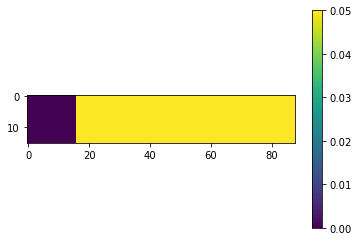

In [39]:
# simmer.initial_array.shape = simmer.dims[:-1]
plt.imshow(simmer.initial_array[cp_i,...])
plt.colorbar()

In [40]:
# simmer.initial_array = initial_array
# simmer.t_eval = np.arange(0,24*60*60,2.0).astype(np.float)
simmer.set_p0(p0)
_, nh, nw, dx = simmer.dims
simmer.t_eval = np.linspace(0,15*60*60,200)
rtime = time.time()
print('start')
simmer.sim(p0, method='RK45')
# simmer.sim(p0, method='BDF')
rtime = time.time() - rtime
print(rtime/60)

start
0.8688387433687846


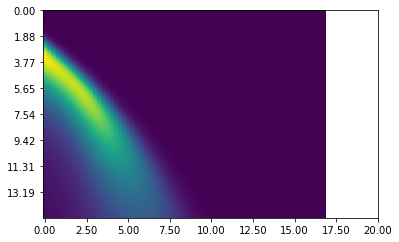

In [43]:
plt.imshow(simmer.sim_arr[:,s_i,0,20:],aspect=1/4)
_ = plt.yticks(np.arange(0,200,25),['{:0.2f}'.format(xx/3600) for xx in simmer.t_eval[np.arange(0,200,25)]])
_ = plt.xticks(np.arange(0,nw,10),['{:0.2f}'.format(xx) for xx in np.arange(0,nw,10)/scale])

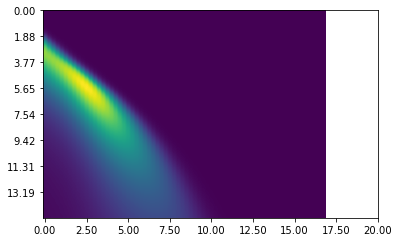

In [9]:
plt.imshow(simmer.sim_arr[:,s_i,0,20:],aspect=1/4)
_ = plt.yticks(np.arange(0,200,25),['{:0.2f}'.format(xx/3600) for xx in simmer.t_eval[np.arange(0,200,25)]])
_ = plt.xticks(np.arange(0,nw,10),['{:0.2f}'.format(xx) for xx in np.arange(0,nw,10)/scale])

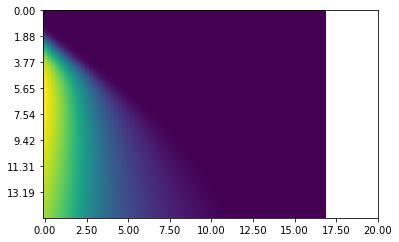

In [10]:
plt.imshow(simmer.sim_arr[:,r_i,0,20:],aspect=1/4)
_ = plt.yticks(np.arange(0,200,25),['{:0.2f}'.format(xx/3600) for xx in simmer.t_eval[np.arange(0,200,25)]])
_ = plt.xticks(np.arange(0,nw,10),['{:0.2f}'.format(xx) for xx in np.arange(0,nw,10)/scale])

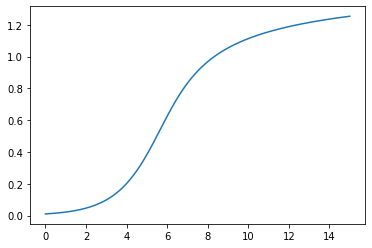

In [82]:
plt.plot(simmer.sim_tvc/3600,simmer.sim_arr[:,cp_i,0,20])

In [10]:
pads_list = []
pads_list.append((simmer.sim_arr.copy(), simmer.sim_tvc.copy()))

In [ ]:
movie_obj = write_movie(simmer.sim_arr[:,:,:,::2], simmer.sim_tvc, skip=1, n_frames=200)
HTML(movie_obj.to_html5_video())

In [11]:

# Define parameter values to sample
# Dc,rc,rS,rR,Hn,Kn,Dn,kn,Da,xa,xs,xS,xr,hS,kS,hR,kR,hC,kC,pa,leak,min_od = p0
xs=0
p0 = np.array([Dc,rc,rS,rR,Hn,Kn,Dn,kn,Da,xa,xs,xS,xr,hS,kS,hR,kR,hC,kC,pa,leak,min_od])

# simmer.t_eval = np.arange(0,24*60*60,2.0).astype(np.float)
# simmer.basedims = np.array([2,22])
# simmer.set_scale(simmer.scale)
simmer.set_p0(p0)

species, nh, nw, dx = simmer.dims
initial_array = np.zeros((species, nh, nw), dtype=np.float64, order='C')
initial_array[n_i,:,:] = 100
initial_array[cs_i,0,:4*scale] = od0
# initial_array[cs_i,:,:] = od0*(np.random.random((nh,nw))<0.19)
# initial_array[cs_i,0,:] = ndi.gaussian_filter(initial_array[cs_i,:,:], scale/8)
initial_array[cp_i,0,4*scale:] = od0
# initial_array[cp_i,:,:] = od0*(np.random.random((nh,nw))<0.25)
# initial_array[cp_i,:,:] = ndi.gaussian_filter(initial_array[cp_i,:,:], scale/8)
# for ind in [cp_i, cs_i]:
#     threshed = initial_array[ind,:,:] > min_od
#     initial_array[ind,:,:] = initial_array[ind,:,:]*threshed

simmer.initial_array = initial_array


simmer.t_eval = np.linspace(0,15*60*60,200)
rtime = time.time()
print('start')
simmer.sim(p0, method='RK45')
# simmer.sim(p0, method='BDF')
rtime = time.time() - rtime
print(rtime/60)

start


/home/jparkin/anaconda3/lib/python3.7/site-packages/scipy/integrate/_ivp/common.py:41: UserWarning: The following arguments have no effect for a chosen solver: `jac`.
  .format(", ".join("`{}`".format(x) for x in extraneous)))


0.20247833331425985


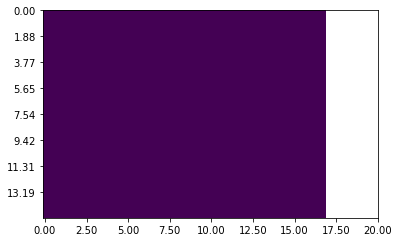

In [16]:
plt.imshow(simmer.sim_arr[:,s_i,0,20:],aspect=1/4)
_ = plt.yticks(np.arange(0,200,25),['{:0.2f}'.format(xx/3600) for xx in simmer.t_eval[np.arange(0,200,25)]])
_ = plt.xticks(np.arange(0,nw,10),['{:0.2f}'.format(xx) for xx in np.arange(0,nw,10)/scale])

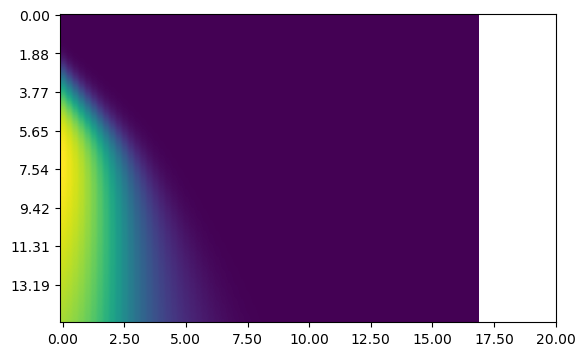

In [88]:
plt.imshow(simmer.sim_arr[:,r_i,0,20:],aspect=1/4)
_ = plt.yticks(np.arange(0,200,25),['{:0.2f}'.format(xx/3600) for xx in simmer.t_eval[np.arange(0,200,25)]])
_ = plt.xticks(np.arange(0,nw,10),['{:0.2f}'.format(xx) for xx in np.arange(0,nw,10)/scale])

In [12]:
pads_list.append((simmer.sim_arr.copy(), simmer.sim_tvc.copy()))

In [14]:
movie_obj = write_movie(simmer.sim_arr, simmer.sim_tvc, skip=1, n_frames=200)
HTML(movie_obj.to_html5_video())

RuntimeError: Requested MovieWriter (ffmpeg) not available

chan:0 pad:0 fit:[ 1.18198237 -3.27517817  3.99999999]
chan:0 pad:1 fit:[ 1.07478285 -3.07961532  2.87500043]
chan:1 pad:0 fit:[ 1.04893659 -1.58278571  8.24999999]


/home/jparkin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Legend does not support None instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


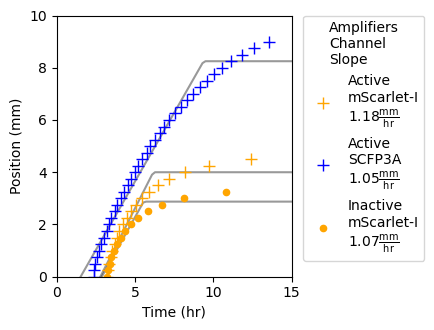

In [130]:

# import downsampled movie
# pad_procs = [procpad1, procpad2]
# pad_styles = ['dashed', 'solid']
pad_styles = ['+', '.']
offset_vals = [4*scale, 4*scale]
# rot_vals = [3.8, -11]
np_slices = np.s_[0,4*scale:], np.s_[0,4*scale:]

chan_vals = [0,1,2]
col_vals = ['yellow','orange','blue']
# max_vals = [10000,5000,10000]
# max_vals = [1e4,500,200]
max_vals = [1e4,1e4,3e4]
# max_vals = [100,30,130]

col_vals = ['yellow','orange','blue']
# frame_vals = np.arange(0,25,1)
plt.style.use('default')
plt.style.use('fast')
fig, axs = plt.subplots(1,1,figsize=(4.5,3.4))
handles = [[None,None],[None,None]]
ys = []
cs = []
ts = []
ps = []
dirs = []
handles = [[None,None],[None,None]]
df_list = []
for np_sl, ls, pad_tup, pad_ind in zip(np_slices, pad_styles, pads_list, [0,1]):
#     procpad = mma.ProcessUnorderedDiff(acq, pad_ind, 2, overwrite=False, bg_option='pos_list',sigma=1,bg_sigma=16)
#     procpad._load_arrs(False)
    sim_arr, sim_tvc = pad_tup
    pixel_size = 1/scale
#     pad_ind = procpad.pad_ind
    spec_inds = [r_i, s_i]
    for chan_ind, spec_i in enumerate(spec_inds):
        c = col_vals[chan_ind+1]
        frame_img = sim_arr[:,[cp_i,spec_i],np_sl[0],np_sl[1]].prod(axis=1)
        if np.all(frame_img <1):
            continue
        thresh_val = np.max([skimage.filters.threshold_otsu(frame_img),1e1])
        bool_arr = frame_img>(thresh_val)
        if np.any(bool_arr):
            tcross = [[simmer.sim_tvc[xvec][0], xi] for xi, xvec in enumerate(bool_arr.T) if np.any(xvec)]
            cross_arr = np.array(tcross)
            h = axs.plot(cross_arr[:,0]/3600, cross_arr[:,1]*pixel_size,c=c,linestyle='none',ms=9,marker=ls)
            handles[pad_ind][chan_ind] = h[0]
            # update lists
#             ys.append(y_val)
#             ts.append(t_val)
#             cs.append(chan_ind)
#             ps.append(procpad.pad_ind)
#             dirs.append(acq.super_dir)
#             axs.set_title("Chan {} Frame {}".format(chan_ind, frame_ind))
            axs.set_ylim([0,10])
            tmp_df = pd.DataFrame(cross_arr, columns=['time','dist'])
            tmp_df['channel'] = chan_ind
            tmp_df['pad'] = pad_ind
            df_list.append(tmp_df)
            axs.set_xlim([0,15])
        axs.set_xlabel('Time (hr)')
        axs.set_ylabel('Position (mm)')

def f_fun(t,p):
    a, b, c = p
    return np.array([np.min([c,xx]) for xx in (a*t + b)])

def res_fun(p, t, y):
    a, b, c = p
    if (a < 0) or (b > 0):
        return -np.inf
    return -1*np.sum(stats.norm.logpdf(f_fun(t,p)-y,scale=0.5))


cols = ['dist','time','channel','pad']
fit_df = pd.concat(df_list,ignore_index=True)
labels=['Active\nmScarlet-I\n{:0.2f}',
        'Active\nSCFP3A\n{:0.2f}',
        'Inactive\nmScarlet-I\n{:0.2f}',
        'Inactive\nSCFP3A\n{:0.2f}']
for key, chan_df in fit_df.groupby(['channel','pad']):
    chan, pad = key
    y_vec = chan_df.dist.values*pixel_size
    t_vec = chan_df.time.values/3600
    p0 = np.array([3,-15,np.max(y_vec)])
    out = opt.minimize(res_fun, p0, args=(t_vec, y_vec))
    color = col_vals[chan]
    sim_t = np.linspace(0,15,80)
    sim_y = f_fun(sim_t, out.x)
    axs.plot(sim_t, sim_y, 'k-',alpha=0.4,zorder=0)
    label_i = (chan)+2*(pad)
    label = labels[label_i]
    labels[label_i] = label.format(out.x[0])+r'$\frac{\mathrm{mm}}{\mathrm{hr}}$'
    print('chan:{} pad:{} fit:{}'.format(chan, pad, out.x))

axs.legend(handles=handles[0]+handles[1], labels=labels,title='Amplifiers\nChannel\nSlope',
          bbox_to_anchor=(1.05,1),loc='upper left',borderaxespad=0.)
fig.tight_layout()
# fig.savefig('/home/jparkin/groupdir/biotek/summary-analysis/figures/nodc_3d_propagation.png')
# fig.savefig('/home/jparkin/groupdir/biotek/summary-analysis/figures/nodc_3d_propagation.pdf')

In [107]:
3600/np.mean(np.diff(pads_list[0][1]))

13.266666666666666

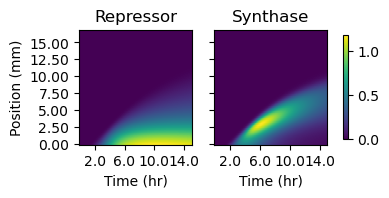

In [13]:
plt.style.use('default')
plt.style.use('fast')
pixel_size = 1/scale
fig, axs = plt.subplots(1,2,figsize=(4,3))
ax = axs[1]
yvec = np.arange(0,nw-5*scale,10)
yvec_labels = ['{:0.2f}'.format(xx) for xx in yvec*pixel_size]
xvec = np.arange(27,200,53)
xvec_labels = ['{:0.1f}'.format(xx/3600) for xx in pads_list[0][1][xvec]]
ax.imshow(pads_list[0][0][:,[cp_i,s_i],0,20:].prod(axis=1).T,aspect=3,origin='lower')
ax.set_xticks(xvec)
ax.set_xticklabels(xvec_labels)
ax.set_xlabel('Time (hr)')
_ = ax.set_yticks(yvec)
_ = ax.set_yticklabels(['' for xx in yvec])

ax.set_title('Synthase')


ax = axs[0]
ax.set_title('Repressor')
h = ax.imshow(pads_list[0][0][:,[cp_i,r_i],0,20:].prod(axis=1).T/np.max(pads_list[0][0][:,r_i,0,20:].T),aspect=3,origin='lower')
ax.set_xticks(xvec)
ax.set_xticklabels(xvec_labels)
ax.set_xlabel('Time (hr)')
_ = ax.set_yticks(yvec)
ax.set_ylabel('Position (mm)')
_ = ax.set_yticklabels(yvec_labels)
plt.colorbar(h,ax=axs,shrink=0.45)
# fig.tight_layout()
# fig.savefig('/home/jparkin/groupdir/biotek/summary-analysis/figures/nodc_3d_heatmap.png',bbox_inches='tight')
# fig.savefig('/home/jparkin/groupdir/biotek/summary-analysis/figures/nodc_3d_heatmap.pdf',bbox_inches='tight')

# this no cell diffusion, with nutrient diffusion, go for 3d 

In [95]:
import importlib
from omnisim import nodc_3d_omnisim as oms
oms = importlib.reload(oms)
# array([1.13884719e-06, 2.57810284e-04, 6.79690366e+01, 3.97094713e+00,
#        1.57994650e-02])
# Params :    ,Dc,      rc,        rS, rR,  Hn, Kn,   Dn,      kn,                   
p0 = np.array([0*1e-5,  2.6e-4, 2e-4, 8e-6,  4, 68,  1.14e-6, (1.6e-2),
# Da,   xa,                xs,  xS,
2e-4, (2e-6), 250, 300, 
#xr, hS,   kS,  hR, kR,  hC,  kC,    pa,  leak   min_od
13, 2.5,  133, 2.3, 40, 2.2, 1.13e4, 3e-5, 0, 0.04], dtype=np.float64)
# Define parameter values to sample
Dc,rc,rS,rR,Hn,Kn,Dn,kn,Da,xa,xs,xS,xr,hS,kS,hR,kR,hC,kC,pa,leak,min_od = p0
od0 = 0.05

simmer = oms.Simulator(16)
scale = simmer.scale
# simmer.set_scale(8)
# simmer.t_eval = np.arange(0,24*60,2).astype(np.float)

In [189]:
ns, nz, nh, nw, _ = simmer.dims
arr_z = nz + 5
# simmer.set_scale(8)
simmer.t_eval = np.arange(0,12*60*60,2).astype(np.float)

simmer.set_p0(p0)

cs_slice, cp_slice, n_slice, a_slice, s_slice, r_slice = simmer.species_slices
scale = simmer.scale

initial_array = np.zeros((arr_z, nh, nw), dtype=np.float64, order='C') + 1e-5
initial_array[n_slice] = 100
s_scale = np.int(scale/2)
mid_slice = np.s_[0,np.int(nh//2-4):np.int(4+nh//2),np.int(nw//2-4):np.int(4+nw//2)]
blob_slice = np.s_[0,np.int(nh//2-scale):np.int(scale+nh//2),np.int(nw//2-scale):np.int(scale+nw//2)]
initial_array[cs_slice][mid_slice] = od0
# initial_array[cs_i,:,:] = od0*(np.random.random((nh,nw))<0.19)
# initial_array[cs_slice][0,:,:] = ndi.gaussian_filter(initial_array[cs_slice][0,...], scale/4)
initial_array[cp_slice][blob_slice] = od0
initial_array[cp_slice][mid_slice] = 0
# initial_array[cp_i,:,:] = od0*(np.random.random((nh,nw))<0.25)
# initial_array[cp_slice][0,:,:] = ndi.gaussian_filter(initial_array[cp_slice][0,...], scale/4)
# for ind in [cp_slice, cs_slice]:
#     threshed = initial_array[ind] > min_od
#     initial_array[ind] = initial_array[ind]*threshed
simmer.initial_array = initial_array.copy()

In [190]:
# simmer.set_p0(p0)

from omnisim.solvers import cn_gmres_3d_split as cn_gmres_3d
cn_gmres_3d = importlib.reload(cn_gmres_3d)
impexp = cn_gmres_3d.CNMGRK(simmer, 0, 2*60, first_step=5e-1)

iteration:0.0 dt:3
0.0
iteration:1000.0 dt:3
110.80185254103147
iteration:2000.0 dt:3
111.45272786688616
iteration:3000.0 dt:3
111.59860228225335
iteration:4000.0 dt:3
111.67902239318293
iteration:5000.0 dt:3
111.79484541610013
iteration:6000.0 dt:3
112.1880019081277
iteration:7000.0 dt:3
112.40612162856215
iteration:8000.0 dt:3
112.37677621805175
iteration:9000.0 dt:3
112.32651578118688


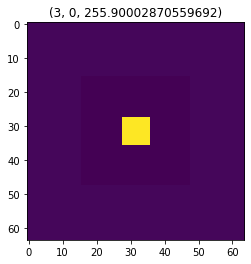

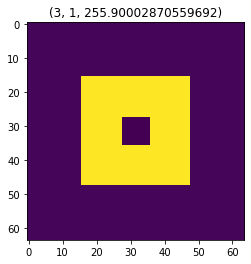

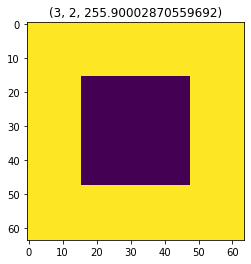

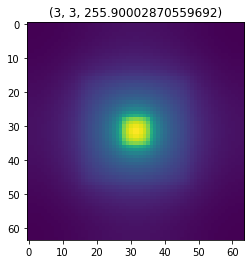

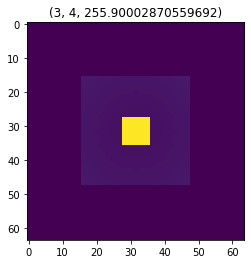

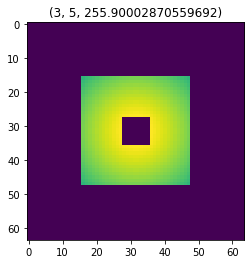

In [191]:
# A = cnmg.cn_lhsA(h)
# x = im_arr[1,:,:,:].flatten()
ns, nz, nh, nw, _ = simmer.dims
arr_z = nz + 5
ys = []
ts = []
for dt in [3]:#,2,5e-1,5e-2]:
    simmer.initial_array = initial_array.copy()
    impexp = cn_gmres_3d.CNMGRK(simmer, 0, 2*60, first_step=dt)
    n_loops = 8*3600/dt
    rtime = time.time()
    for i in np.arange(n_loops):
        status, msg = impexp._step_impl()
        if status==False:
            print(msg)
            break
        if (i%20)==0:
            ys.append(impexp.y.copy())
            ts.append(i*dt)
        if (i%1000)==0:
            print("iteration:{} dt:{}".format(i,dt))
            print(dt*i/(time.time() - rtime))
    
    rtime = time.time() - rtime
    err_arr = impexp.y
    err_arr = err_arr.reshape((arr_z,nh,nw))
    for i in np.arange(oms.species):
        plt.figure()
        plt.imshow(err_arr[simmer.z0_slice][i,:,:])
        plt.title((dt, i, rtime))
#     b = cnmg.cn_rhsb_wrxn(x)
# #     cnmg.w_cycle(x,b,0)
#     out = splinalg.gmres(A, b, x)
# #     x = out[0]
#     if np.mod(i,n_loops/10)==0:
#         x = impexp.y.copy()
#         print(i)
#         print(impexp.cnmg_solver.dt)
#         x.shape = (ns,nh,nw)
#         axs[np.int(10*i/n_loops)].imshow(x[[cp_i,s_i],:,:].prod(axis=0))
#         x.shape = ns*nh*nw

In [192]:
ys_reshaped = [xx.reshape((1,arr_z,nh,nw)) for xx in ys]

In [193]:
ys_stack = np.concatenate(ys_reshaped,axis=0)

In [194]:
movie_obj = write_movie(ys_stack[:,simmer.z0_slice[0],:,:], np.array(ts), skip=1, n_frames=200)
HTML(movie_obj.to_html5_video())

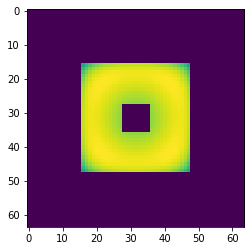

In [207]:
img = ys_stack[190,simmer.z0_slice[0],:,:]
plt.imshow(img[[cp_i,s_i],...].prod(axis=0))

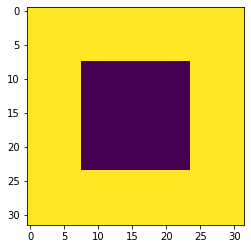

In [76]:
d_y = simmer.f_rxn_wrapper(0, simmer.initial_array.flatten())
y_new = simmer.initial_array[simmer.z0_slice].flatten() + 0.25*d_y
y_new.shape = 6,32,32
plt.imshow(y_new[2,...])

In [195]:
cs_slice, cp_slice, n_slice, a_slice, s_slice, r_slice = simmer.species_slices
ahl_arr = ys_stack[:,a_slice[0],...]
syn_arr = ys_stack[:,s_slice[0],...].prod(axis=1)
cell_arr = (ys_stack[:,cs_slice[0],...]+ys_stack[:,cp_slice[0],...]).sum(axis=1)
syn_arr = syn_arr*cell_arr
scale = simmer.scale
arr = (ahl_arr[:,1,:,:]-ahl_arr[:,0,:,:])
arr *= Da*scale**2
arr /= xa*scale*(1e-4+syn_arr)
arr += 1
tmp_arr = xa*scale*(syn_arr)
bool_arr = tmp_arr < 5e-2
arr[bool_arr] = 0

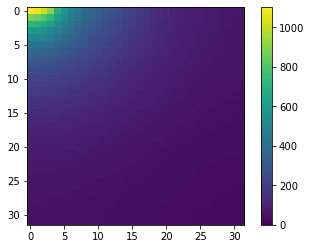

In [197]:
plt.imshow(ahl_arr[230,:,np.int(nh//2),np.int(nw//2):],aspect=1,interpolation='none',vmin=0)
plt.colorbar()

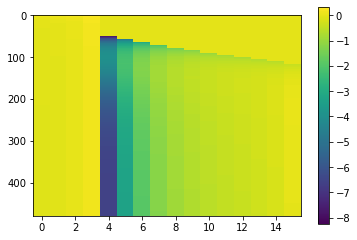

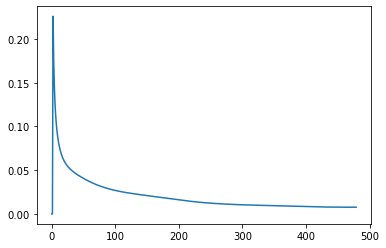

In [201]:
plt.imshow(arr[:,np.int(nh//2),np.int(nw//2):np.int(nw//2)+scale],aspect=1/40,interpolation='none')
plt.colorbar()
plt.figure()
plt.plot(arr[:,np.int(nh//2),np.int(nw//2)+2])

In [66]:
plt.style.use('default')
plt.style.use('fast')
fig, ax = plt.subplots(1,1,figsize=(3,2))
cs_slice, cp_slice, n_slice, a_slice, s_slice, r_slice = simmer.species_slices
img_arr = pads_list[0][0]
ahl_arr = ys_stack[a_slice]
syn_arr = ys_stack[s_slice]*(ys_stack[cs_slice]+ys_stack[cp_slice])
scale = simmer.scale
arr = (ahl_arr[:,1,:,:].T-ahl_arr[:,0,:,:])
arr *= Da*scale**2
arr /= xa*scale*(1e-4+syn_arr + syn_arr)
arr += 1
tmp_arr = xa*scale*(syn_arr)
bool_arr = tmp_arr < 5e-2
arr[bool_arr] = 0
h = ax.imshow(arr[:,:],aspect=1,interpolation='none',origin='lower')
pixel_size = 1/scale
xvec = np.arange(27,200,53)
xvec_labels = ['{:0.1f}'.format(xx/3600) for xx in pads_list[0][1][xvec]]
ax.set_xticks(xvec)
ax.set_xticklabels(xvec_labels)
ax.set_xlabel('Time (hr)')
yvec = np.arange(0,nw,10)
yvec_labels = ['{:0.2f}'.format(xx) for xx in yvec*pixel_size]
_ = ax.set_yticks(yvec[::2])
ax.set_ylabel('Position (mm)')
_ = ax.set_yticklabels(yvec_labels[::2])
plt.colorbar(h,ax=ax,shrink=0.65)
fig.tight_layout()
_ = ax.set_title('')
# fig.savefig('/home/jparkin/groupdir/biotek/summary-analysis/figures/nodc_3d_depthratio.png')
# fig.savefig('/home/jparkin/groupdir/biotek/summary-analysis/figures/nodc_3d_depthratio.pdf')

(21504,)

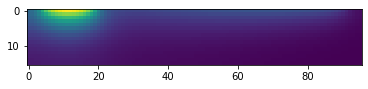

In [114]:
_ = plt.imshow(ys_stack[200,a_slice[0],np.int(nh//2),:],vmin=0)

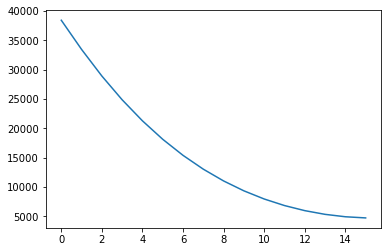

In [115]:
_ = plt.plot(ys_stack[200,a_slice[0],np.int(nh//2),40])

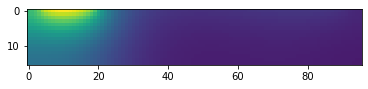

In [116]:
_ = plt.imshow(err_arr[simmer.species_slices[a_i]][:,np.int(nh//2),:],interpolation='none',vmin=0)

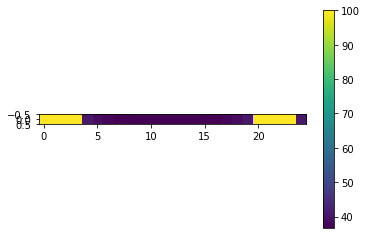

In [117]:
_ = plt.imshow(err_arr[simmer.species_slices[n_i]][:5,np.int(nh//2),:25])
plt.colorbar()

In [118]:
import importlib
from omnisim import nodc_3d_omnisim as oms
oms = importlib.reload(oms)
# array([1.13884719e-06, 2.57810284e-04, 6.79690366e+01, 3.97094713e+00,
#        1.57994650e-02])
# Params :    ,Dc,      rc,        rS, rR,  Hn, Kn,   Dn,      kn,                   
p0 = np.array([0*1e-5,  2.6e-4, 2e-4, 8e-6,  4, 68,  1.14e-6, (1.6e-2),
# Da,   xa,                xs,  xS,
7e-4, (1e-2)/(16/2.25)**2, 0, 300, 
#xr, hS,   kS,  hR, kR,  hC,  kC,    pa,  leak   min_od
13, 2.5,  133, 2.3, 40, 2.2, 1.13e4, 3e-5, 0, 0.05], dtype=np.float64)
# Define parameter values to sample
Dc,rc,rS,rR,Hn,Kn,Dn,kn,Da,xa,xs,xS,xr,hS,kS,hR,kR,hC,kC,pa,leak,min_od = p0
od0 = 0.1

simmer = oms.Simulator(8)
scale = simmer.scale
# simmer.set_scale(8)
# simmer.t_eval = np.arange(0,24*60,2).astype(np.float)

In [119]:
ns, nz, nh, nw, _ = simmer.dims
arr_z = nz + 5
# simmer.set_scale(8)
simmer.t_eval = np.arange(0,12*60*60,2).astype(np.float)

simmer.set_p0(p0)

cs_slice, cp_slice, n_slice, a_slice, s_slice, r_slice = simmer.species_slices
scale = simmer.scale

initial_array = np.zeros((arr_z, nh, nw), dtype=np.float64, order='C') + 1e-5
initial_array[n_slice] = 100
s_scale = np.int(scale/2)
initial_array[cs_slice][0,s_scale:-s_scale,s_scale:2*scale+s_scale] = od0
# initial_array[cs_i,:,:] = od0*(np.random.random((nh,nw))<0.19)
initial_array[cs_slice][0,:,:] = ndi.gaussian_filter(initial_array[cs_slice][0,...], scale/4)
initial_array[cp_slice][0,s_scale:-s_scale,3*scale:-s_scale] = od0
# initial_array[cp_i,:,:] = od0*(np.random.random((nh,nw))<0.25)
initial_array[cp_slice][0,:,:] = ndi.gaussian_filter(initial_array[cp_slice][0,...], scale/4)
for ind in [cp_slice, cs_slice]:
    threshed = initial_array[ind] > min_od
    initial_array[ind] = initial_array[ind]*threshed
simmer.initial_array = initial_array.copy()

In [120]:
# simmer.set_p0(p0)

from omnisim.solvers import cn_gmres_3d
cn_gmres_3d = importlib.reload(cn_gmres_3d)
impexp = cn_gmres_3d.CNMGRK(simmer, 0, 2*60, first_step=5e-1)

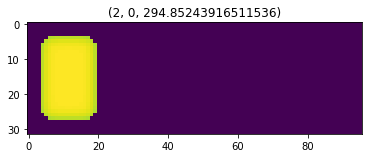

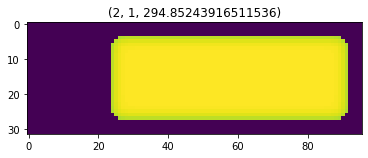

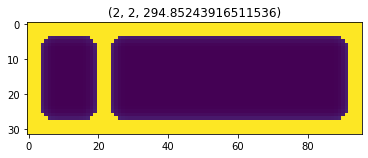

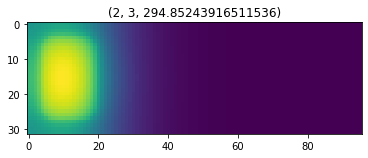

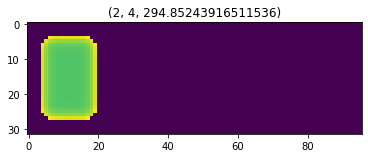

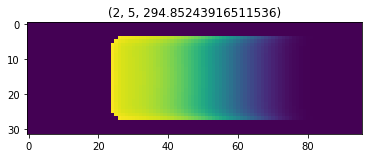

In [121]:
# A = cnmg.cn_lhsA(h)
# x = im_arr[1,:,:,:].flatten()
ns, nz, nh, nw, _ = simmer.dims
arr_z = nz + 5
ys = []
ts = []
for dt in [2]:#,2,5e-1,5e-2]:
    simmer.initial_array = initial_array.copy()
    impexp = cn_gmres_3d.CNMGRK(simmer, 0, 2*60, first_step=dt)
    n_loops = 10000
    rtime = time.time()
    for i in np.arange(n_loops):
        impexp._step_impl()
        if i%20:
            continue
        else:
            ys.append(impexp.y.copy())
            ts.append(i*dt)
    rtime = time.time() - rtime
    err_arr = impexp.y
    err_arr = err_arr.reshape((arr_z,nh,nw))
    for i in np.arange(species):
        plt.figure()
        plt.imshow(err_arr[simmer.z0_slice][i,:,:])
        plt.title((dt, i, rtime))
#     b = cnmg.cn_rhsb_wrxn(x)
# #     cnmg.w_cycle(x,b,0)
#     out = splinalg.gmres(A, b, x)
# #     x = out[0]
#     if np.mod(i,n_loops/10)==0:
#         x = impexp.y.copy()
#         print(i)
#         print(impexp.cnmg_solver.dt)
#         x.shape = (ns,nh,nw)
#         axs[np.int(10*i/n_loops)].imshow(x[[cp_i,s_i],:,:].prod(axis=0))
#         x.shape = ns*nh*nw

In [122]:
ys_reshaped = [xx.reshape((1,arr_z,nh,nw)) for xx in ys]

In [123]:
ys_stack = np.concatenate(ys_reshaped,axis=0)

In [124]:
movie_obj = write_movie(ys_stack[:,simmer.z0_slice[0],:,:], np.array(ts), skip=1, n_frames=200)
HTML(movie_obj.to_html5_video())

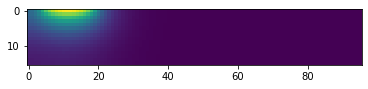

In [125]:
_ = plt.imshow(ys_stack[200,a_slice[0],np.int(nh//2),:],vmin=0)

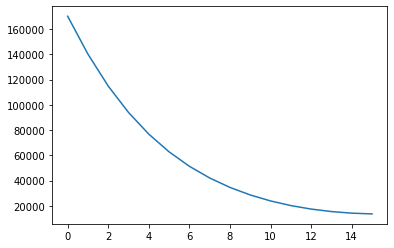

In [129]:
_ = plt.plot(ys_stack[200,a_slice[0],np.int(nh//2),10])

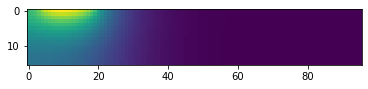

In [127]:
_ = plt.imshow(err_arr[simmer.species_slices[a_i]][:,np.int(nh//2),:],interpolation='none',vmin=0)

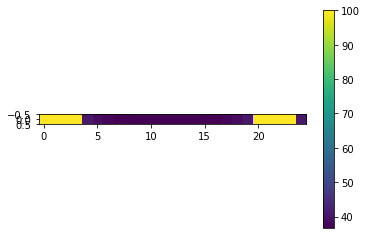

In [128]:
_ = plt.imshow(err_arr[simmer.species_slices[n_i]][:5,np.int(nh//2),:25])
plt.colorbar()

# this no cell diffusion, with nutrient diffusion, go for 3d 

In [107]:
import importlib
from omnisim import nodc_3d_omnisim as oms
oms = importlib.reload(oms)
# array([1.13884719e-06, 2.57810284e-04, 6.79690366e+01, 3.97094713e+00,
#        1.57994650e-02])
# Params :    ,Dc,      rc,        rS, rR,  Hn, Kn,   Dn,      kn,                   
p0 = np.array([0*1e-5,  2.6e-4, 2e-4, 8e-6,  4, 68,  1.14e-6, (1.6e-2),
# Da,   xa,                xs,  xS,
7e-4, (1e-2)/(16/2.25)**2, 250, 300, 
#xr, hS,   kS,  hR, kR,  hC,  kC,    pa,  leak   min_od
13, 2.5,  133, 2.3, 40, 2.2, 1.13e4, 3e-5, 0, 0.05], dtype=np.float64)
# Define parameter values to sample
Dc,rc,rS,rR,Hn,Kn,Dn,kn,Da,xa,xs,xS,xr,hS,kS,hR,kR,hC,kC,pa,leak,min_od = p0
od0 = 0.1

simmer = oms.Simulator(8)
scale = simmer.scale
# simmer.set_scale(8)
# simmer.t_eval = np.arange(0,24*60,2).astype(np.float)

In [108]:
ns, nz, nh, nw, _ = simmer.dims
arr_z = nz + 5
# simmer.set_scale(8)
simmer.t_eval = np.arange(0,12*60*60,2).astype(np.float)

simmer.set_p0(p0)

cs_slice, cp_slice, n_slice, a_slice, s_slice, r_slice = simmer.species_slices
scale = simmer.scale

initial_array = np.zeros((arr_z, nh, nw), dtype=np.float64, order='C') + 1e-5
initial_array[n_slice] = 100
s_scale = np.int(scale/2)
initial_array[cs_slice][0,s_scale:-s_scale,s_scale:2*scale+s_scale] = od0
# initial_array[cs_i,:,:] = od0*(np.random.random((nh,nw))<0.19)
initial_array[cs_slice][0,:,:] = ndi.gaussian_filter(initial_array[cs_slice][0,...], scale/4)
initial_array[cp_slice][0,s_scale:-s_scale,3*scale:-s_scale] = od0
# initial_array[cp_i,:,:] = od0*(np.random.random((nh,nw))<0.25)
initial_array[cp_slice][0,:,:] = ndi.gaussian_filter(initial_array[cp_slice][0,...], scale/4)
for ind in [cp_slice, cs_slice]:
    threshed = initial_array[ind] > min_od
    initial_array[ind] = initial_array[ind]*threshed
simmer.initial_array = initial_array.copy()

In [109]:
# simmer.set_p0(p0)

from omnisim.solvers import cn_gmres_3d
cn_gmres_3d = importlib.reload(cn_gmres_3d)
impexp = cn_gmres_3d.CNMGRK(simmer, 0, 2*60, first_step=5e-1)

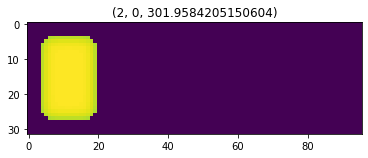

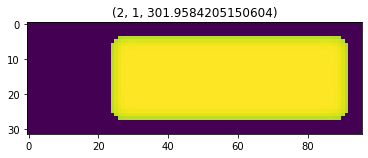

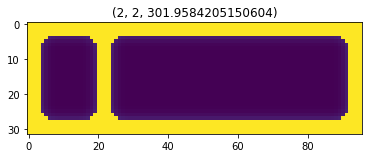

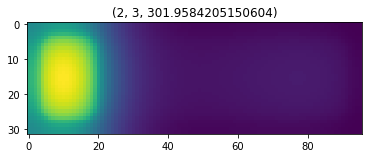

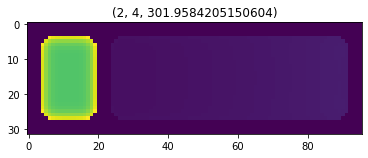

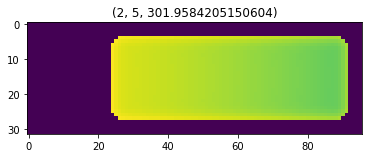

In [110]:
# A = cnmg.cn_lhsA(h)
# x = im_arr[1,:,:,:].flatten()
ns, nz, nh, nw, _ = simmer.dims
arr_z = nz + 5
ys = []
ts = []
for dt in [2]:#,2,5e-1,5e-2]:
    simmer.initial_array = initial_array.copy()
    impexp = cn_gmres_3d.CNMGRK(simmer, 0, 2*60, first_step=dt)
    n_loops = 10000
    rtime = time.time()
    for i in np.arange(n_loops):
        impexp._step_impl()
        if i%20:
            continue
        else:
            ys.append(impexp.y.copy())
            ts.append(i*dt)
    rtime = time.time() - rtime
    err_arr = impexp.y
    err_arr = err_arr.reshape((arr_z,nh,nw))
    for i in np.arange(species):
        plt.figure()
        plt.imshow(err_arr[simmer.z0_slice][i,:,:])
        plt.title((dt, i, rtime))
#     b = cnmg.cn_rhsb_wrxn(x)
# #     cnmg.w_cycle(x,b,0)
#     out = splinalg.gmres(A, b, x)
# #     x = out[0]
#     if np.mod(i,n_loops/10)==0:
#         x = impexp.y.copy()
#         print(i)
#         print(impexp.cnmg_solver.dt)
#         x.shape = (ns,nh,nw)
#         axs[np.int(10*i/n_loops)].imshow(x[[cp_i,s_i],:,:].prod(axis=0))
#         x.shape = ns*nh*nw

In [111]:
ys_reshaped = [xx.reshape((1,arr_z,nh,nw)) for xx in ys]

In [112]:
ys_stack = np.concatenate(ys_reshaped,axis=0)

In [113]:
movie_obj = write_movie(ys_stack[:,simmer.z0_slice[0],:,:], np.array(ts), skip=1, n_frames=200)
HTML(movie_obj.to_html5_video())

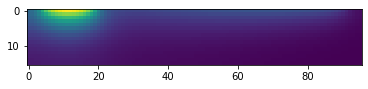

In [114]:
_ = plt.imshow(ys_stack[200,a_slice[0],np.int(nh//2),:],vmin=0)

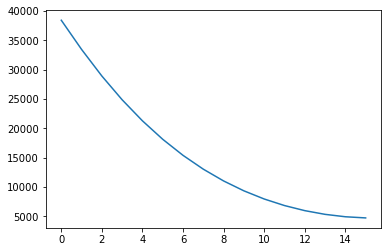

In [115]:
_ = plt.plot(ys_stack[200,a_slice[0],np.int(nh//2),40])

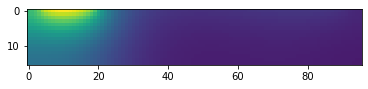

In [116]:
_ = plt.imshow(err_arr[simmer.species_slices[a_i]][:,np.int(nh//2),:],interpolation='none',vmin=0)

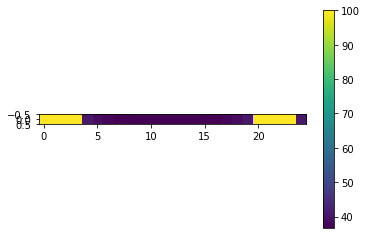

In [117]:
_ = plt.imshow(err_arr[simmer.species_slices[n_i]][:5,np.int(nh//2),:25])
plt.colorbar()

# 3d, nodc, aprx majority is failing right now

In [110]:
import importlib
from omnisim import aprx_majority_nodc3d_omnisim as oms
oms = importlib.reload(oms)
# array([1.13884719e-06, 2.57810284e-04, 6.79690366e+01, 3.97094713e+00,
#        1.57994650e-02])
# Define parameter values to sample
od0 = 0.2

# simmer.set_scale(8)
# simmer.t_eval = np.arange(0,24*60,2).astype(np.float)

In [111]:
from omnisim.solvers import cn_gmres_3d_split as cn_gmres_3d
cn_gmres_3d = importlib.reload(cn_gmres_3d)
impexp = cn_gmres_3d.CNMGRK(simmer, 0, 2*60, first_step=5e-1)

/home/jparkin/anaconda3/lib/python3.7/site-packages/scipy/sparse/data.py:126: RuntimeWarning: invalid value encountered in multiply
  return self._with_data(self.data * other)


In [172]:
simmer = oms.Simulator(4)
scale = simmer.scale


# Params :    ,Dc,      rc,        rS, rR,  Hn, Kn,   Dn,      kn,                   
p0 = np.array([0*1e-5,  2.6e-4, 2e-4, 8e-6,  4, 68,  1.14e-6, (1.6e-2),
# Da,   xa,                xs,  xS,
2e-4, (2e-6), 250, 300, 
#xr, hS,   kS,  hR, kR,  hC,  kC,    pa,  leak   min_od
13, 2.5,  133, 2.3, 40, 2.2, 1.13e4, 3e-5, 0, 0.05], dtype=np.float64)

Dc,rc,rS,rR,Hn,Kn,Dn,kn,Da,xa,xs,xS,xr,hS,kS,hR,kR,hC,kC,pa,leak,min_od = p0
ca_i, cb_i, cp_i, n_i, aa_i, ab_i, sa_i, sb_i, ra_i, rb_i, spa_i, spb_i, rpa_i, rpb_i = np.arange(oms.species)
1/(Da*6*simmer.scale**2)

52.08333333333333

In [173]:
def new_init_conditions(simmer, weights=[1,1,100]):
    scale = simmer.scale
    ns, nz, nh, nw, _ = simmer.dims
    arr_z = 2*nz + ns-2
    slice_list = simmer.species_slices
    z0_slice = simmer.z0_slice
    simmer.basedims = np.array([2,22,22])
    simmer.set_scale(4)
    simmer.t_eval = np.linspace(0,11*60*60,200)
    ns, nh, nw = simmer.initial_array.shape
    simmer.initial_array = np.zeros_like(simmer.initial_array)
    simmer.initial_array[slice_list[n_i]] = 100
    odval = 1e-3*scale**2/4
    r_vec = np.linspace(1e-3,7,1000)*simmer.scale
    r_probs = r_vec / np.sum(r_vec)
    appx_distr = (r_vec)/np.sum(r_vec)
    ci_vec = oms.cell_inds
    for ci, ci_spots in zip(ci_vec, weights):
        spec_frame = np.zeros_like(simmer.initial_array[0,...])
        for i in range(np.int(ci_spots)):
            r = np.random.choice(r_vec,1,p=appx_distr)
            theta = np.random.uniform(0,2*np.pi,size=(1,))
            x, y = np.int(r*np.cos(theta)+nw/2), np.int(r*np.sin(theta)+nh/2)
            spec_frame[y,x] = odval
        simmer.initial_array[simmer.species_slices[ci]]= spec_frame
#     return simmer
#     plt.imshow(simmer.initial_array[simmer.species_slices[cp_i]][0,...])

In [199]:
def new_init_conditions(simmer, weights=[100,100]):
    scale = simmer.scale
    ns, nz, nh, nw, _ = simmer.dims
    arr_z = 2*nz + ns-2
    slice_list = simmer.species_slices
    z0_slice = simmer.z0_slice
    simmer.basedims = np.array([2,22,22])
    simmer.set_scale(2)
    simmer.t_eval = np.linspace(0,11*60*60,200)
    ns, nh, nw = simmer.initial_array.shape
    simmer.initial_array = np.zeros_like(simmer.initial_array)
    simmer.initial_array[slice_list[n_i]] = 100
    odval = 100#1e-3*scale**2/4
    r_vec = np.linspace(1e-3,7,1000)*simmer.scale
    r_probs = r_vec / np.sum(r_vec)
    appx_distr = (r_vec)/np.sum(r_vec)
    ci_vec = oms.ahl_inds
    for ci, ci_spots in zip(ci_vec, weights):
        spec_frame = np.zeros_like(simmer.initial_array[0,...])
        for i in range(np.int(ci_spots)):
            r = np.random.choice(r_vec,1,p=appx_distr)
            theta = np.random.uniform(0,2*np.pi,size=(1,))
            x, y = np.int(r*np.cos(theta)+nw/2), np.int(r*np.sin(theta)+nh/2)
            spec_frame[y,x] = odval
        simmer.initial_array[simmer.species_slices[ci]]= spec_frame
#     return simmer
#     plt.imshow(simmer.initial_array[simmer.species_slices[cp_i]][0,...])

In [200]:
new_init_conditions(simmer, [20,20])

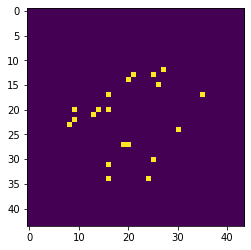

In [201]:
plt.imshow(simmer.initial_array[simmer.species_slices[aa_i]][0,...])

iteration:0 dt:12
0.0
iteration:10 dt:12
147.64590666373712
iteration:20 dt:12
140.79267062894752
iteration:30 dt:12
136.12946977148417
iteration:40 dt:12
134.60451857093085
iteration:50 dt:12
133.79894799668622
iteration:60 dt:12
133.24690290957003
iteration:70 dt:12
132.91147904721836
iteration:80 dt:12
132.36112062123274
iteration:90 dt:12
132.04751246076157


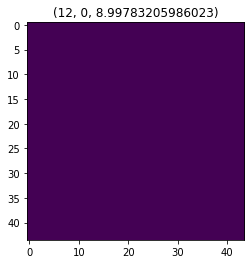

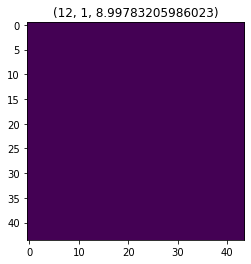

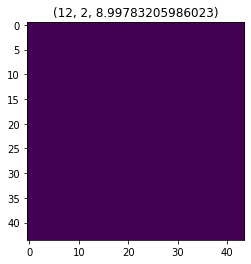

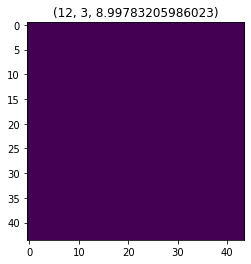

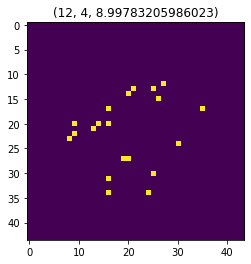

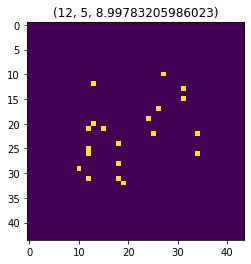

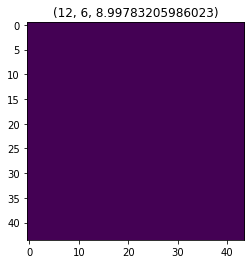

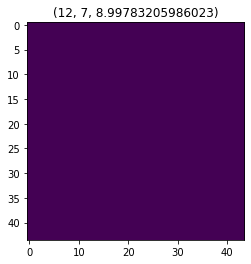

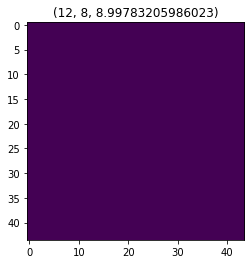

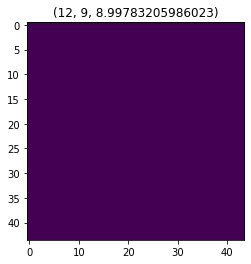

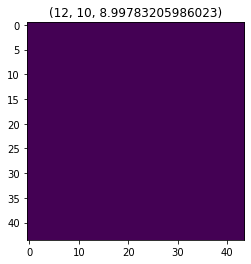

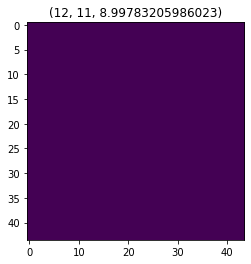

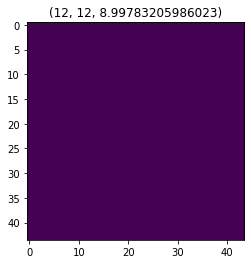

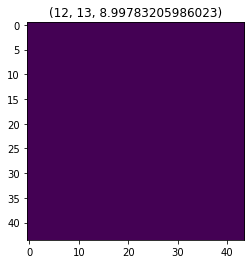

In [205]:
# A = cnmg.cn_lhsA(h)
# x = im_arr[1,:,:,:].flatten()
species = oms.species
ns, nz, nh, nw, _ = simmer.dims
arr_z = nz*2 + species-2
ys = []
ts = []
for dt in [12]:#,2,5e-1,5e-2]:
#     new_init_conditions(simmer, [2,1,100])
    simmer.set_p0(p0)
    impexp = cn_gmres_3d.CNMGRK(simmer, 0, 2*60, first_step=dt,rk_step=0.5)
    n_loops = 100
    rtime = time.time()
    for i in np.arange(n_loops):
        status, msg = impexp._step_impl()
        if status==False:
            print(msg)
            break
        if (i%2)==0:
            ys.append(impexp.y.copy())
            ts.append(i*dt)
        if (i%10)==0:
            print("iteration:{} dt:{}".format(i,dt))
            print(dt*i/(time.time() - rtime))

    rtime = time.time() - rtime
    err_arr = impexp.y
    err_arr = err_arr.reshape((arr_z,nh,nw))
    for i in np.arange(species):
        plt.figure()
        plt.imshow(err_arr[simmer.z0_slice][i,:,:])
        plt.title((dt, i, rtime))


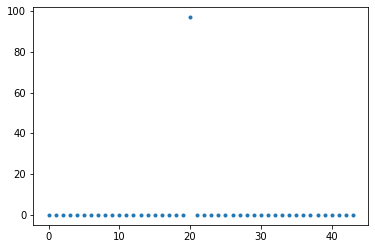

In [208]:
plt.plot(ys[40][simmer.species_slices[aa_i]][0,14,:],'.')

In [170]:
ys_reshaped = [xx.reshape((1,arr_z,nh,nw)) for xx in ys]

In [171]:
ys_stack = np.concatenate(ys_reshaped,axis=0)

In [219]:
movie_obj = write_movie(ys_stack[:,simmer.z0_slice[0],:,:], np.array(ts), skip=1, n_frames=200)
HTML(movie_obj.to_html5_video())